In [136]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sympy import OperationNotSupported
from tqdm import tqdm
from xgboost import XGBClassifier


def visualize_results_box_plot(results):
    # Prepare data for plotting
    df_results = pd.DataFrame({
        'Classifier': [],
        'Metric': [],
        'Value': [],
        'Epoch': []
    })
    
    for clf_name, metrics in results.items():
        for epoch, (loss, acc) in enumerate(zip(metrics['loss'], metrics['accuracy'])):
            df_results = pd.concat([df_results, pd.DataFrame({
                'Classifier': [clf_name, clf_name],
                'Metric': ['Log Loss', 'Accuracy'],
                'Value': [loss, acc],
                'Epoch': [epoch, epoch]
            })])
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Log Loss
    sns.boxplot(data=df_results[df_results['Metric'] == 'Log Loss'],
                x='Classifier', y='Value', ax=ax1, palette='Set2')
    ax1.set_title('Log Loss Distribution')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Plot Accuracy
    sns.boxplot(data=df_results[df_results['Metric'] == 'Accuracy'],
                x='Classifier', y='Value', ax=ax2, palette='Set2')
    ax2.set_title('Accuracy Distribution')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    return fig

In [137]:
"""
Data analysis inspired by following article: https://www.kaggle.com/code/priyanshusethi/classification-model-comparison-diseases

In this article the author considered the target to be a 'Outcome variable' which is a binary variable.

However I am using the 'Disease' as the target variable which is a multi-class variable. I expect this to change 
(maybe significantly), the performance results.
"""

# Import functions from the analysis package
file_name = "Disease Symptoms and Patient Profile Dataset_exported"
dataset_path = Path(f"./kaggle/{file_name}.csv")
data = pd.read_csv(dataset_path)

# Analyze disease frequency
disease_counts = data['Disease'].value_counts()
print("Disease frequency distribution:")
print("Most common diseases:")
print(disease_counts.head())
print("\nRarest diseases:")
print(disease_counts.tail())
print(f"\nNumber of diseases with only one occurrence: {sum(disease_counts == 1)}")

# Filter out rare diseases (less than 2 occurrences)
min_instances = 5
frequent_diseases = disease_counts[disease_counts >= min_instances].index
data_filtered = data[data['Disease'].isin(frequent_diseases)]

print(f"\nOriginal number of samples: {len(data)}")
print(f"Number of samples after filtering rare diseases: {len(data_filtered)}")
print(f"Original number of diseases: {len(disease_counts)}")
print(f"Number of diseases after filtering: {len(frequent_diseases)}")


Disease frequency distribution:
Most common diseases:
Disease
Asthma          23
Stroke          16
Osteoporosis    14
Hypertension    10
Diabetes        10
Name: count, dtype: int64

Rarest diseases:
Disease
Autism Spectrum Disorder (ASD)    1
Hypoglycemia                      1
Fibromyalgia                      1
Eating Disorders (Anorexia,...    1
Williams Syndrome                 1
Name: count, dtype: int64

Number of diseases with only one occurrence: 61

Original number of samples: 349
Number of samples after filtering rare diseases: 236
Original number of diseases: 116
Number of diseases after filtering: 32


In [138]:

def adjust_predicted_probabilities(y_pred, n_classes):
    """
    Ensure predicted probabilities have probabilities for all classes.
    """
    n_samples, n_pred_classes = y_pred.shape
    if n_pred_classes < n_classes:
        adjusted_pred = np.zeros((n_samples, n_classes))
        adjusted_pred[:, :n_pred_classes] = y_pred
        return adjusted_pred
    return y_pred

def train_and_test_sklearn_classifier(clf, data, n_epoch=42):
    """
    
    Train and test a classifier on the given data.
    @param clf: classifier to be trained and tested
    @param data: dataset to be used for training and testing
    @return: log loss of the classifier
    """
    # create new copy of the data
    data = data.copy()
    
    features = data.iloc[:, 1:]
    target = data.iloc[:, 0]
    print(f"Features to be used for prediction:\n{features.head()}")
    print(f"Target variable:\n{target.head()}")
    
    x_train,x_test,y_train,y_test = train_test_split(features, target, test_size=0.2, random_state=n_epoch)
    
    oe = OrdinalEncoder(categories=[['No','Yes']])
    x_train_fever = oe.fit_transform(x_train["Fever"].array.reshape(-1, 1))
    x_test_fever = oe.transform(x_test["Fever"].array.reshape(-1, 1))
    
    be = OrdinalEncoder(categories=[['No','Yes']])
    x_train_cough = be.fit_transform(x_train["Cough"].array.reshape(-1, 1))
    x_test_cough = be.transform(x_test["Cough"].array.reshape(-1, 1))
    
    ce = OrdinalEncoder(categories=[['No','Yes']])
    x_train_fat = ce.fit_transform(x_train["Fatigue"].array.reshape(-1, 1))
    x_test_fat = ce.transform(x_test["Fatigue"].array.reshape(-1, 1))
    
    de = OrdinalEncoder(categories=[['No','Yes']])
    x_train_breath = de.fit_transform(x_train["Difficulty Breathing"].array.reshape(-1, 1))
    x_test_breath = de.transform(x_test["Difficulty Breathing"].array.reshape(-1, 1))
    
    fe = OrdinalEncoder(categories=[['Low','Normal',"High"]])
    x_train_blood = fe.fit_transform(x_train["Blood Pressure"].array.reshape(-1, 1))
    x_test_blood = fe.transform(x_test["Blood Pressure"].array.reshape(-1, 1))
    
    ge = OrdinalEncoder(categories=[['Low','Normal',"High"]])
    x_train_chol = ge.fit_transform(x_train["Cholesterol Level"].array.reshape(-1, 1))
    x_test_chol = ge.transform(x_test["Cholesterol Level"].array.reshape(-1, 1))
    
    gender_ohe = OneHotEncoder(drop='first')
    x_train_gender = gender_ohe.fit_transform(x_train['Gender'].array.reshape(-1, 1)).toarray() # The OneHotEncoder produces a sparse matrix, which may not concatenate directly with NumPy arrays (e.g., x_train_fever, x_train_cough). Sparse matrix stores only non-zero values to optimize space (CSR)
    x_test_gender = gender_ohe.transform(x_test['Gender'].array.reshape(-1, 1)).toarray()
    
    outcome_ohe = OneHotEncoder(drop='first')
    x_train_outcome = outcome_ohe.fit_transform(x_train['Outcome Variable'].array.reshape(-1, 1)).toarray()
    x_test_outcome = outcome_ohe.fit_transform(x_test['Outcome Variable'].array.reshape(-1, 1)).toarray()
    
    x_train_transformed = np.concatenate((x_train_fever,x_train_cough,x_train_fat,x_train_breath,x_train_blood,x_train_chol,x_train_gender, x_train_outcome),axis=1)
    
    x_test_transformed = np.concatenate((x_test_fever,x_test_cough,x_test_fat,x_test_breath,x_test_blood,x_test_chol, x_test_gender, x_test_outcome),axis=1)
    
    # Multi-class encoding for target variable, since it is a multi-class variable
    le = LabelEncoder()
    le.fit(list(y_train) + list(y_test))
    
    y_train_transformed = le.transform(y_train)
    y_test_transformed = le.transform(y_test)
    
     # Train the model
    clf.fit(x_train_transformed, y_train_transformed)
    
    # Ensure pred contains probabilities
    if hasattr(clf, "predict_proba"):
        pred_proba = clf.predict_proba(x_test_transformed)
        pred_proba = adjust_predicted_probabilities(pred_proba, len(le.classes_))  # Adjust probabilities
    else:
        raise OperationNotSupported(f"The classifier {clf.__class__.__name__} does not support predict_proba method.")
    
    loss = log_loss(
        y_true=y_test_transformed, 
        y_pred=pred_proba, 
        labels=np.arange(len(le.classes_))
    )
    
    accuracy = clf.score(x_test_transformed, y_test_transformed)
    return loss, accuracy

    

In [139]:
def train_and_test_xgboost(data, n_epoch=42):
    """
    Train and test an XGBoost classifier on the given data.
    @param data: dataset to be used for training and testing
    @return: log loss of the classifier
    """
    # create new copy of the data
    data = data.copy()
    
    # Initialize our label encoders
    le_disease = LabelEncoder()
    le_gender = LabelEncoder()
    
    # Encode the target variable (Disease)
    data['Disease_encoded'] = le_disease.fit_transform(data['Disease'])
    
    # Encode Gender
    data['Gender_encoded'] = le_gender.fit_transform(data['Gender'])
    
    # Convert Yes/No to 1/0 for symptom columns
    binary_columns = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
    for col in binary_columns:
        data[col] = (data[col] == 'Yes').astype(int)
    
    # Convert Blood Pressure to numeric
    bp_map = {'Low': 0, 'Normal': 1, 'High': 2}
    data['Blood_Pressure_encoded'] = data['Blood Pressure'].map(bp_map)
    
    # Convert Cholesterol Level to numeric
    chol_map = {'Low': 0, 'Normal': 1, 'High': 2}
    data['Cholesterol_encoded'] = data['Cholesterol Level'].map(chol_map)
    
    # Prepare features and target
    features = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 
               'Age', 'Gender_encoded', 'Blood_Pressure_encoded', 'Cholesterol_encoded']
    
    X = data[features]
    y = data['Disease_encoded']
    
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=n_epoch, 
        stratify=y
    )
    
    # Calculate class weights to handle imbalance
    class_weights = dict(zip(
        range(len(frequent_diseases)),
        len(y_train) / (len(frequent_diseases) * np.bincount(y_train))
    ))
    
    # Initialize XGBoost classifier
    n_classes = len(frequent_diseases)
    print(f"\nTraining XGBoost with {n_classes} diseases")
    
    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=n_classes,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        random_state=42,
        eval_metric=['mlogloss'],
        early_stopping_rounds=10,
        use_label_encoder=False,
        scale_pos_weight=1,  # We're handling class weights differently
        min_child_weight=1,  # Help with class imbalance
        subsample=0.8,       # Prevent overfitting
        colsample_bytree=0.8 # Prevent overfitting
    )
    
    # Train the model
    xgb_model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        # Convert class weights to sample weights
        sample_weight=np.array([class_weights[y] for y in y_train])
    )
    
    # Get predictions
    y_pred_proba = xgb_model.predict_proba(X_test)
    y_pred = xgb_model.predict(X_test)
    
    # Calculate metrics
    loss = log_loss(y_test, y_pred_proba)
    accuracy = xgb_model.score(X_test, y_test)

    return loss, accuracy

In [140]:
"""
ANALYSE dataset on different classifiers to assess performance when predicting the disease. Since the author is predicting multi-class variable needs to be used a `predict_proba()` method to calculate probability of each class (in other words it tells certainty of the prediction.

For binary classification, the `predict()` method is used.
"""


def run_experiment(data, n_epochs):
    """
    Run an experiment to train and test multiple classifiers on the given data.
    @param data: 
    @param n_epochs: 
    @return: 
    """
    # Define classifiers
    classifiers = {
        'Naive Bayes': GaussianNB(),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=7), # tried 3, 5, 7, 10 -> 7 is the best
        'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=5, random_state=42),
        'LightGBM': LGBMClassifier(n_estimators=10, random_state=42), # TODO - resolve Warnings
        'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000), # Multi-layer Perceptron
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=42, max_iter=1000) # doesn't support predict_proba
    }
    
    # Store results
    results = {name: {'loss': [], 'accuracy': []} for name in classifiers.keys()}
    
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch + 1}/{n_epochs}")
    
        # Train and test each classifier
        for name, clf in tqdm(classifiers.items(), desc="Training classifiers"):
            try:
                print(f"\nTraining and testing {name}:")
                
                if name == 'XGBoost':
                    loss, accuracy = train_and_test_xgboost(data)
                else:
                    loss, accuracy = train_and_test_sklearn_classifier(clf, data)
                    
                # print("\nModel Performance:")
                # print(f"Log Loss: {loss:.4f}")
                # print(f"Accuracy: {accuracy*100:.2f}%")      
                # Save the results
                results[name]['loss'].append(loss)
                results[name]['accuracy'].append(accuracy)
            except Exception as e:
                print(f"Error: {e}")
                # results[name] = 0
    return results


In [141]:
def visualize_results(results, n_epochs):
    """
    Visualize the log loss and accuracy over epochs for each classifier.
    @param results: The results dictionary containing log loss and accuracy for each classifier.
    @param n_epochs: The number of epochs.
    """
    # Prepare data for plotting
    epochs = list(range(1, n_epochs + 1))
    
    plt.figure(figsize=(12, 6))
    
    # Plot Log Loss for each classifier
    for clf_name, metrics in results.items():
        plt.plot(epochs, metrics['loss'], label=f'{clf_name} - Log Loss', marker='o', linestyle='-', markersize=5)
    
    plt.title('Log Loss Comparison Over Epochs for Classifiers', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Log Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot Accuracy for each classifier
    plt.figure(figsize=(12, 6))
    for clf_name, metrics in results.items():
        plt.plot(epochs, metrics['accuracy'], label=f'{clf_name} - Accuracy', marker='s', linestyle='--', markersize=5)
    
    plt.title('Accuracy Comparison Over Epochs for Classifiers', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/5


Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training and testing Naive Bayes:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Training and testing K-Neighbors:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age 

/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Training classifiers:  57%|█████▋    | 4/7 [00:00<00:00,  5.01it/s]


Training and testing LightGBM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force

Training classifiers:  71%|███████▏  | 5/7 [00:01<00:00,  4.92it/s]


Training and testing MLP Classifier:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object


/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training classifiers: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Training and testing SVM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Epoch 2/5


Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training and testing Naive Bayes:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Training and testing K-Neighbors:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age 

Training classifiers:  71%|███████▏  | 5/7 [00:00<00:00,  5.38it/s]


Training and testing LightGBM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force

/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training classifiers: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]



Training and testing SVM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Epoch 3/5


Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training and testing Naive Bayes:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Training and testing K-Neighbors:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age 

Training classifiers:  71%|███████▏  | 5/7 [00:00<00:00,  5.80it/s]


Training and testing LightGBM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force

/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training classifiers: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]



Training and testing SVM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Epoch 4/5


Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training and testing Naive Bayes:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Training and testing K-Neighbors:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age 

Training classifiers:  71%|███████▏  | 5/7 [00:00<00:00,  5.64it/s]


Training and testing LightGBM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force

/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training classifiers: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]



Training and testing SVM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Epoch 5/5


Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training and testing Naive Bayes:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object

Training and testing K-Neighbors:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age 

Training classifiers:  71%|███████▏  | 5/7 [00:00<00:00,  5.46it/s]


Training and testing LightGBM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force

/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training classifiers: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_48135/2290615106.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results[df_results['Metric'] == 'Log Loss'],
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_48135/2290615106.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m000


Training and testing SVM:
Features to be used for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object


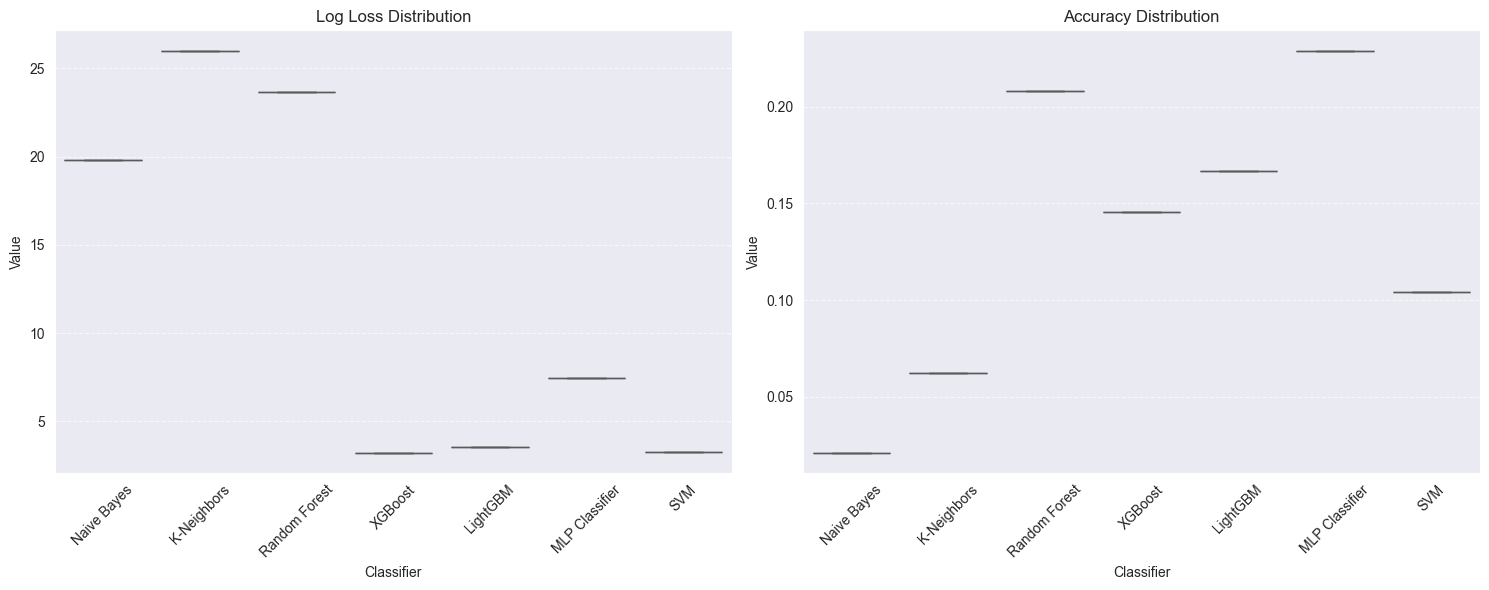

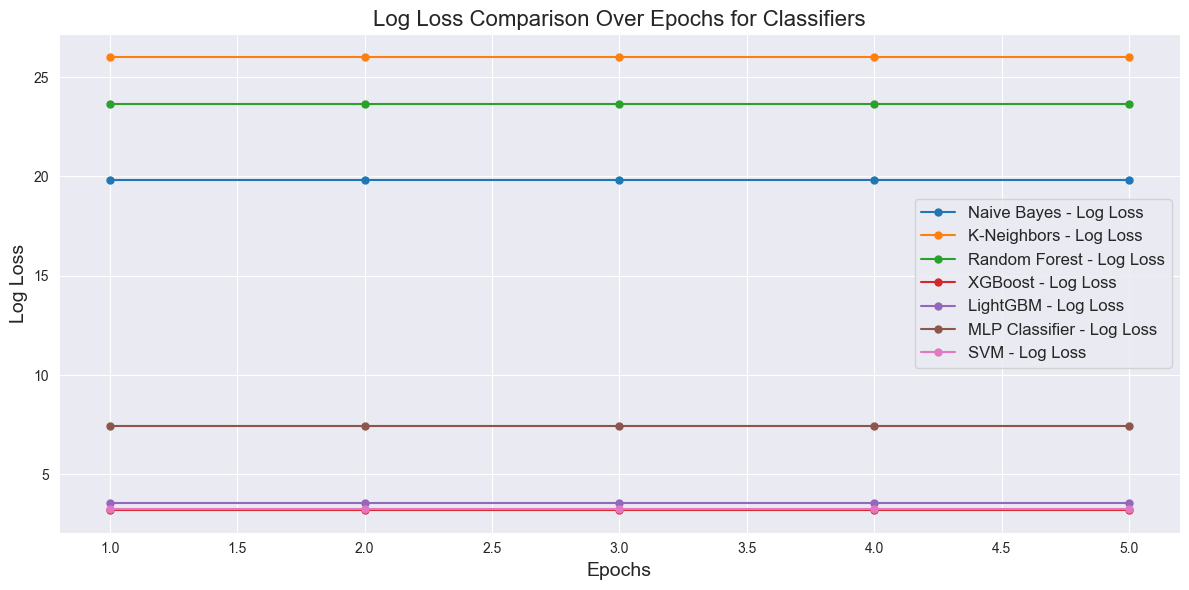

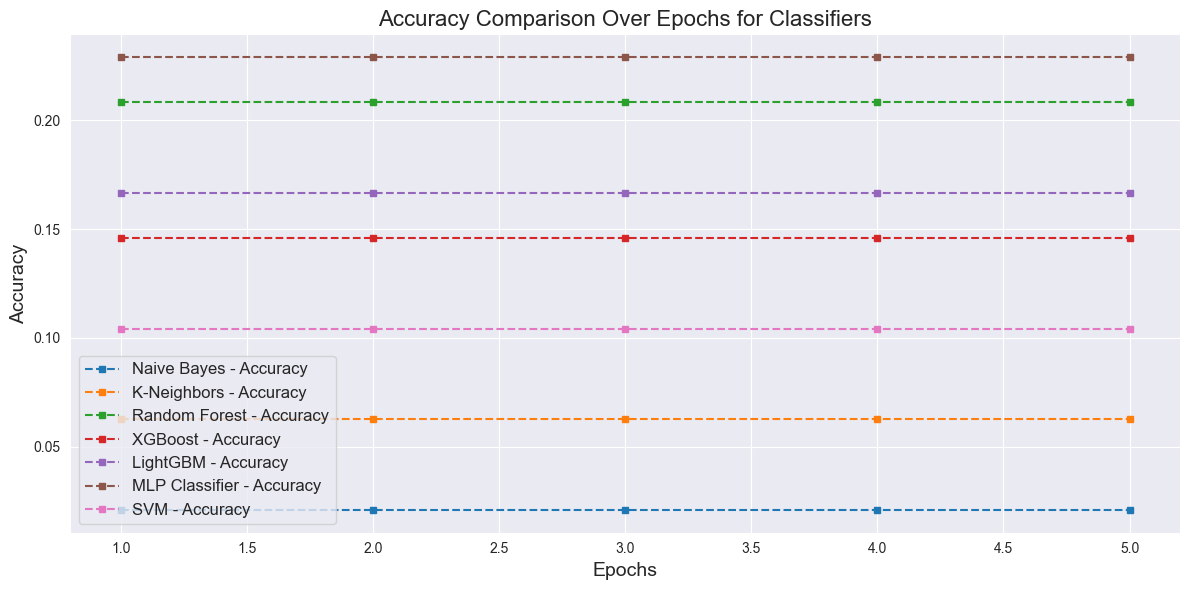


Top 3 Best Performing Classifiers:

Rank 1: XGBoost
Mean Log Loss: 3.2049
Mean Accuracy: 14.58%

Rank 2: SVM
Mean Log Loss: 3.2575
Mean Accuracy: 10.42%

Rank 3: LightGBM
Mean Log Loss: 3.5384
Mean Accuracy: 16.67%


In [142]:
# Run experiments
n_epochs = 5
results = run_experiment(data_filtered, n_epochs)

# Create visualization
fig = visualize_results_box_plot(results)
plt.show()

# Visualize results
visualize_results(results, n_epochs)

# Sort classifiers by mean loss
sorted_clfs = sorted(
    results.items(), 
    key=lambda x: np.mean(x[1]['loss'])
)

# Get the top three
top_3_clfs = sorted_clfs[:3]

# Print the top 3 classifiers
print("\nTop 3 Best Performing Classifiers:")
for rank, (clf_name, metrics) in enumerate(top_3_clfs, start=1):
    mean_loss = np.mean(metrics['loss'])
    mean_accuracy = np.mean(metrics['accuracy']) * 100
    print(f"\nRank {rank}: {clf_name}")
    print(f"Mean Log Loss: {mean_loss:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.2f}%")

# Find best performing classifier
# best_clf = min(results.items(), key=lambda x: np.mean(x[1]['loss']))
# print(f"\nBest performing classifier: {best_clf[0]}")
# print(f"Mean Log Loss: {np.mean(best_clf[1]['loss']):.4f}")
# print(f"Mean Accuracy: {np.mean(best_clf[1]['accuracy'])*100:.2f}%")

In [143]:
"""
Analysis of XGBoost classifier on the dataset.
"""

# Read the data and create DataFrame
data = pd.read_csv("./kaggle/Disease Symptoms and Patient Profile Dataset_exported.csv")

# Analyze disease frequency
disease_counts = data['Disease'].value_counts()
print("Disease frequency distribution:")
print("Most common diseases:")
print(disease_counts.head())
print("\nRarest diseases:")
print(disease_counts.tail())
print(f"\nNumber of diseases with only one occurrence: {sum(disease_counts == 1)}")

# Filter out rare diseases (less than 2 occurrences)
min_instances = 10
frequent_diseases = disease_counts[disease_counts >= min_instances].index
data_filtered = data[data['Disease'].isin(frequent_diseases)]

print(f"\nOriginal number of samples: {len(data)}")
print(f"Number of samples after filtering rare diseases: {len(data_filtered)}")
print(f"Original number of diseases: {len(disease_counts)}")
print(f"Number of diseases after filtering: {len(frequent_diseases)}")

# Initialize our label encoders
le_disease = LabelEncoder()
le_gender = LabelEncoder()

# Encode the target variable (Disease)
data_filtered['Disease_encoded'] = le_disease.fit_transform(data_filtered['Disease'])

# Encode Gender
data_filtered['Gender_encoded'] = le_gender.fit_transform(data_filtered['Gender'])

# Convert Yes/No to 1/0 for symptom columns
binary_columns = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
for col in binary_columns:
    data_filtered[col] = (data_filtered[col] == 'Yes').astype(int)

# Convert Blood Pressure to numeric
bp_map = {'Low': 0, 'Normal': 1, 'High': 2}
data_filtered['Blood_Pressure_encoded'] = data_filtered['Blood Pressure'].map(bp_map)

# Convert Cholesterol Level to numeric
chol_map = {'Low': 0, 'Normal': 1, 'High': 2}
data_filtered['Cholesterol_encoded'] = data_filtered['Cholesterol Level'].map(chol_map)

# Prepare features and target
features = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 
           'Age', 'Gender_encoded', 'Blood_Pressure_encoded', 'Cholesterol_encoded']

X = data_filtered[features]
y = data_filtered['Disease_encoded']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Calculate class weights to handle imbalance
class_weights = dict(zip(
    range(len(frequent_diseases)),
    len(y_train) / (len(frequent_diseases) * np.bincount(y_train))
))

# Initialize XGBoost classifier
n_classes = len(frequent_diseases)
print(f"\nTraining XGBoost with {n_classes} diseases")

# Set up using Claude LLM
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=5,
    random_state=42,
    eval_metric=['mlogloss'],
    early_stopping_rounds=10,
    use_label_encoder=False,
    scale_pos_weight=1,  # We're handling class weights differently
    min_child_weight=1,  # Help with class imbalance
    subsample=0.8,       # Prevent overfitting
    colsample_bytree=0.8 # Prevent overfitting
)

# Train the model
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
    # Convert class weights to sample weights
    sample_weight=np.array([class_weights[y] for y in y_train])
)

# Get predictions
y_pred_proba = xgb_model.predict_proba(X_test)
y_pred = xgb_model.predict(X_test)

# Calculate metrics
loss = log_loss(y_test, y_pred_proba)
accuracy = xgb_model.score(X_test, y_test)

print("\nModel Performance:")
print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Feature importance analysis
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Detailed classification report
print("\nClassification Report:")

# Get all classes in the dataset
all_classes = np.arange(len(le_disease.classes_))

# target_names = le_disease.classes_  # Original class names

# Only print the report for classes that appear in the test set
unique_test_classes = np.unique(y_test)
target_names = [le_disease.inverse_transform([i])[0] for i in unique_test_classes]
print(classification_report(y_test, y_pred, labels=unique_test_classes, target_names=target_names)) # labels=unique_test_classes

# Example predictions
print("\nExample Predictions:")
n_examples = 10
random_indices = np.random.choice(len(X_test), n_examples)
for idx in random_indices:
    true_disease = le_disease.inverse_transform([y_test.iloc[idx]])[0]
    pred_proba = y_pred_proba[idx]
    pred_disease = le_disease.inverse_transform([pred_proba.argmax()])[0]
    confidence = pred_proba.max()
    
    print(f"\nTrue Disease: {true_disease}")
    print(f"Predicted Disease: {pred_disease}")
    print(f"Confidence: {confidence:.4f}")

Disease frequency distribution:
Most common diseases:
Disease
Asthma          23
Stroke          16
Osteoporosis    14
Hypertension    10
Diabetes        10
Name: count, dtype: int64

Rarest diseases:
Disease
Autism Spectrum Disorder (ASD)    1
Hypoglycemia                      1
Fibromyalgia                      1
Eating Disorders (Anorexia,...    1
Williams Syndrome                 1
Name: count, dtype: int64

Number of diseases with only one occurrence: 61

Original number of samples: 349
Number of samples after filtering rare diseases: 83
Original number of diseases: 116
Number of diseases after filtering: 6

Training XGBoost with 6 diseases

Model Performance:
Log Loss: 1.6029
Accuracy: 0.4706

Top 5 Most Important Features:
                Feature  Importance
3  Difficulty Breathing    0.356769
4                   Age    0.162322
7   Cholesterol_encoded    0.126515
0                 Fever    0.108057
5        Gender_encoded    0.091368

Classification Report:
              precis

/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_48135/337877283.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Disease_encoded'] = le_disease.fit_transform(data_filtered['Disease'])
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_48135/337877283.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Gender_encoded'] = le_gender.fit_transform(data_filtered['Gender'])
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_48135/337877283.py:40: Setti